# Classificação de Sentimentos com Redes Neurais Convolucionais

## Etapa 1: Importação das bibliotecas

In [1]:
import re
import math
import string
import random
import zipfile
import numpy as np
import spacy as sp
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from bs4 import BeautifulSoup
from tensorflow.keras import layers

In [2]:
tf.__version__

'2.1.0'

## Etapa 2: Pré-processamento dos dados

### Carregamento dos arquivos

In [3]:
path = 'trainingandtestdata.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [4]:
cols = ['sentiment','id','date','query','user','text']
df_train = pd.read_csv('trainingandtestdata/train.csv', header=None,
                      names = cols, engine = 'python', encoding = 'latin1')

In [5]:
df_train.shape

(1600000, 6)

In [6]:
df_train.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df_train.tail()

,sentiment,id,date,query,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [8]:
df_train.sentiment.unique()

array([0, 4], dtype=int64)

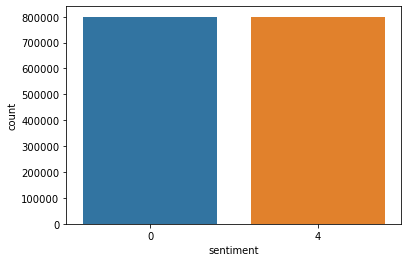

In [9]:
sns.countplot(x = 'sentiment', data = df_train);

In [10]:
df_test = pd.read_csv('trainingandtestdata/test.csv', header = None,
                     names = cols, engine = 'python', encoding = 'latin1')
df_test.shape

(498, 6)

In [11]:
df_test.head()

,sentiment,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [12]:
df_test.sentiment.unique()

array([4, 0, 2], dtype=int64)

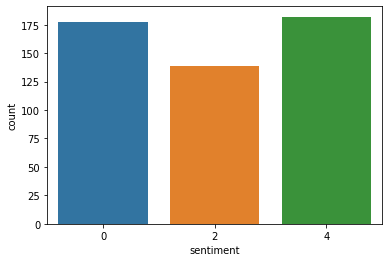

In [13]:
sns.countplot(x = 'sentiment', data = df_test);

## Pré-processamento
### Limpeza

In [14]:
data = df_train.copy()
data.drop(['id','date','query','user'], axis = 1, inplace = True)

In [15]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [16]:
X = data.iloc[:, 1].values
X

array(["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
       "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       ..., 'Are you ready for your MoJo Makeover? Ask me for details ',
       'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
       'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H '],
      dtype=object)

In [17]:
X.shape

(1600000,)

In [18]:
type(X)

numpy.ndarray

In [19]:
y = data.iloc[:,0].values
y

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

In [20]:
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, test_size = 0.85, stratify = y)

In [21]:
X.shape, y.shape

((240000,), (240000,))

In [22]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 4], dtype=int64), array([120000, 120000], dtype=int64))

In [23]:
def preprocess(tweet:str)->str:
    """
    Recebe a frase(tweet) do tipo String:
    --> remove nome de usuário '@...'
    --> remove urls
    --> remove números e algumas pontuações
    --> remove excesso de espaços
    
    Exemplo:
    -> preprocess('@switchfoot http://twitpic.com/2ylzl - Awww, that\'s a bummer. You shoulda got David Carr of Third Day to do it. ;D')
    -> return 'Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'
    --------------------------------------------------------------------------------------
    
    """
    
    tweet = BeautifulSoup(tweet, 'lxml').get_text()         # instancia o documento
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)            # rmove no de usuário @...
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)  # remove urls
    tweet = re.sub(r"[^A-Za-z.!?]", ' ', tweet)             # remove números e algumas pontuações
    tweet = re.sub(r" +",' ', tweet).lstrip()               # remove excesso de espaços
    
    return tweet

In [24]:
text = '@switchfoot http://twitpic.com/2ylzl - Awww, that\'s a bummer. You shoulda got David Carr of Third Day to do it. ;D'

In [25]:
text = preprocess(text)
text

'Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

In [26]:
!python -m spacy download en

Link simb¢lico criado para C:\ProgramData\Anaconda3\envs\nlp_dl\lib\site-packages\spacy\data\en <<===>> C:\ProgramData\Anaconda3\envs\nlp_dl\lib\site-packages\en_core_web_sm
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[+] Linking successful
C:\ProgramData\Anaconda3\envs\nlp_dl\lib\site-packages\en_core_web_sm -->
C:\ProgramData\Anaconda3\envs\nlp_dl\lib\site-packages\spacy\data\en
You can now load the model via spacy.load('en')


You should consider upgrading via the 'C:\ProgramData\Anaconda3\envs\nlp_dl\python.exe -m pip install --upgrade pip' command.


In [27]:
nlp = sp.load('en')
nlp

In [28]:
stop_words = sp.lang.en.STOP_WORDS
print(stop_words)

{'ourselves', 'your', 'though', 'thence', 'where', '’s', 'yours', 'ours', 'further', 'twenty', 'whereafter', 'you', 'none', 'noone', 'go', 'make', 'were', 'also', 'could', 'three', 'what', 'really', 'herein', 'latterly', 'unless', 'indeed', 'much', 'bottom', 'nobody', 'beside', 'has', 'other', 'nevertheless', 'empty', 'through', 'so', 'until', 'its', 'an', 'something', 'me', 'four', 'our', 'toward', 'hereby', 'every', 'next', 'just', 'on', 'are', 'say', 'anyone', 'hers', 'very', 'even', 'only', 'seeming', 'there', 'is', 'to', "'s", 'everywhere', 'else', 'i', 'nor', 'last', 'within', 'back', 'their', '‘s', 'us', '‘m', 'show', 'ca', 'must', 'anyway', 'beyond', 'after', 'why', 'my', 'eleven', 'under', 'nine', 'forty', 'before', 'mine', 'too', 'hundred', 'in', 'since', 'among', 'afterwards', 'both', 'many', 'doing', 'due', 'together', '‘re', 'over', 'meanwhile', 'side', 'one', 'with', 'nothing', 'anything', 'own', 'them', 'during', '’d', '’ve', 'than', 'amongst', 'amount', 'less', 'her', "

In [29]:
len(stop_words)

326

In [30]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [31]:
def clean_doc(tweet:str)->str:
    """
    Recebe a frase(tweet) do tipo String:
    --> converte os caracteres para minúsculas
    --> instancia o documento spaCy
    --> Tokeniza as sentenças
    --> remove a pontuação
    
    Exemplo:
    -> clean_doc('Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D')
    -> return 'awww s bummer shoulda got david carr day d'
    --------------------------------------------------------------------------------------
    
    """
    tweet = tweet.lower()            # transforma os caracteres para minúsculas
    document = nlp(tweet)            # instancia o documento spaCy
    
    words = []
    # percorre o documento e tokeniza
    for token in document:
        words.append(token.text)     # insere o token na lista
        
    # percorre a lista de tokens e remove as stop words
    words = [word for word in words
             if word not in stop_words and word not in string.punctuation]
    
    words = ' '.join([str(el) for el in words])
        
    return words

In [32]:
# Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D

In [33]:
text1 = clean_doc(text)
text1

'awww s bummer shoulda got david carr day d'

In [34]:
data_clean = [clean_doc(preprocess(tweet)) for tweet in X]

In [35]:
for _ in range(10):
    print(data_clean[random.randint(0, len(data_clean) - 1)])

rainbow layered cupcakes today celebrating end classes crazy amused impressed love thanks
good night wish hung guess nannys like work later
louise good chilling work tomorrow weeks ohh
hai arianna thx follow twitter sy gak .. hehe
leaving laptop learn german .. ll miss
hung misty today
clearly bad start day
ty info believe
search damn lyrics lol
nerves wrecking stomach wish d stop


In [36]:
data_labels = y
data_labels[data_labels == 4] = 1
data_labels

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [37]:
np.unique(data_labels)

array([0, 1], dtype=int64)

### Tokenização

In [38]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)

In [39]:
tokenizer.vocab_size

52812

In [40]:
print(tokenizer.subwords)

['s_', 'm_', 't_', ' ... ', 'good_', ' .. ', 'like_', 'got_', 'day_', 'going_', 'nt_', 'love_', 'u_', 'don_', ' ...', 'work_', 'today_', 'time_', 'know_', 'new_', 'll_', 'want_', 'think_', 'oh_', 'lol_', 'need_', 'hope_', 'thanks_', 've_', 'night_', 'home_', 'great_', 'feel_', 'miss_', 'd_', ' .... ', 'day', 'wish_', 'lol', 'morning_', 'na_', 'twitter_', 'getting_', 'gon_', 'today', 'happy_', 'bad_', 'watching_', 'haha_', 'sorry_', 'tomorrow_', 'nice_', 'didn_', 'come_', 'way_', ' ..', 'sleep_', 'sad_', 'fun_', 'yeah_', 'wait_', 'n_', 'hate_', 'work', 'hey_', 'right_', 'people_', 'better_', 'bed_', 'tonight_', 'school_', 'wanna_', 'little_', 'yes_', 'having_', 'y_', 'long_', 'week_', 'best_', 'time', 'thank_', 'days_', 'watch_', 'won_', 'let_', 'ur_', 'e_', 'feeling_', 'ok_', 'awesome_', 'good', 'sure_', 'o_', 'working_', 'looking_', 'tomorrow', 'ready_', 'r_', 'went_', 'night', 'find_', 'man_', 'life_', 'trying_', 'look_', 'pretty_', 'weekend_', 'tired_', 'thing_', 'omg_', 'guys_', 'm

In [41]:
ids = tokenizer.encode('i am happy')
ids

[261, 3372, 393]

In [42]:
text = tokenizer.decode(ids)
text

'i am happy'

In [43]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [44]:
for _ in range(10):
    print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[12, 20740]
[150, 40, 101, 12735, 10199, 3255, 1657]
[18144, 24, 2, 9698, 29, 12108]
[29164, 2070, 13341, 535, 1880, 23634, 2908, 3, 757]
[5703, 8761, 606, 457, 345, 270, 408, 146, 58, 1417, 7, 611]
[1, 8646]
[51395, 641, 4, 5, 191, 143, 6, 209, 838]
[73, 1315, 15790, 12701, 8273, 290, 1555, 32096, 1985, 6414, 9897]
[365, 27, 86, 450]
[665, 17, 570, 711, 3241, 973, 125, 3, 1180]


### Padding

In [45]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

54

In [46]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                           value = 0,
                                                           padding = 'post',
                                                           maxlen = max_len)

In [47]:
for _ in range(10):
    print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[2192    7    1  732 1882 1835    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[52665     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
[  110  2081 44345   269 30862  2081 32884     4  1007   500   357    11
  3181    39     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
[116   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

### Spliting into training/testing set

In [48]:
X_train, X_test, y_train, y_test = train_test_split(data_inputs, data_labels,
                                                    test_size = 0.3, stratify = data_labels)

In [49]:
X_train[0]

array([  906,   994,  8019,   131, 17930,  1114,   427,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0])

In [50]:
X_train.shape, y_train.shape

((168000, 54), (168000,))

In [51]:
X_test.shape, y_test.shape

((72000, 54), (72000,))

# Etapa 3: Construção do modelo

<img src='images/arqui_CNN.jpg'>

In [52]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                vocab_size,
                emb_dim = 128,
                nb_filters = 50,
                ffn_units = 512,
                nb_classes = 2,
                dropout_rate = 0.1,
                training = False,
                name = "dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size, emb_dim)
        
        self.bigram = layers.Conv1D(
            filters = nb_filters, kernel_size = 2, padding = 'same', activation = 'relu')
        
        self.trigram = layers.Conv1D(
            filters = nb_filters, kernel_size = 3, padding = 'same', activation = 'relu')
        
        self.fourgram = layers.Conv1D(
            filters = nb_filters, kernel_size = 4, padding = 'same', activation = 'relu')
        
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
        self.dropout = layers.Dropout(rate = dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
        else:
            self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')
            
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

# Etapa 4: Treinamento
## Configuração dos parâmetros

In [53]:
vocab_size = tokenizer.vocab_size
vocab_size

52812

In [54]:
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(y_train))
nb_classes

2

In [55]:
dropout_rate = 0.2
nb_epochs = 5

## Treinamento

In [56]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
           ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [57]:
if nb_classes == 2:
    Dcnn.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
else:
    Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])    

In [58]:
checkpoint_path = './ckpts_#1'
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored')

In [59]:
history = Dcnn.fit(X_train, y_train,
                  batch_size = batch_size,
                  epochs = nb_epochs,
                  verbose = 1,
                  validation_split = 0.10)
ckpt_manager.save()

Train on 151200 samples, validate on 16800 samples
Epoch 1/5
151200/151200 [==============================] - 553s 4ms/sample - loss: 0.5092 - accuracy: 0.7460 - val_loss: 0.4773 - val_accuracy: 0.7664
Epoch 2/5
151200/151200 [==============================] - 525s 3ms/sample - loss: 0.3703 - accuracy: 0.8347 - val_loss: 0.5055 - val_accuracy: 0.7613
Epoch 3/5
151200/151200 [==============================] - 525s 3ms/sample - loss: 0.1963 - accuracy: 0.9179 - val_loss: 0.7364 - val_accuracy: 0.7395
Epoch 4/5
151200/151200 [==============================] - 528s 3ms/sample - loss: 0.1010 - accuracy: 0.9585 - val_loss: 1.1400 - val_accuracy: 0.7360
Epoch 5/5
151200/151200 [==============================] - 525s 3ms/sample - loss: 0.0692 - accuracy: 0.9711 - val_loss: 1.2214 - val_accuracy: 0.7371


'./ckpts_#1\\ckpt-1'

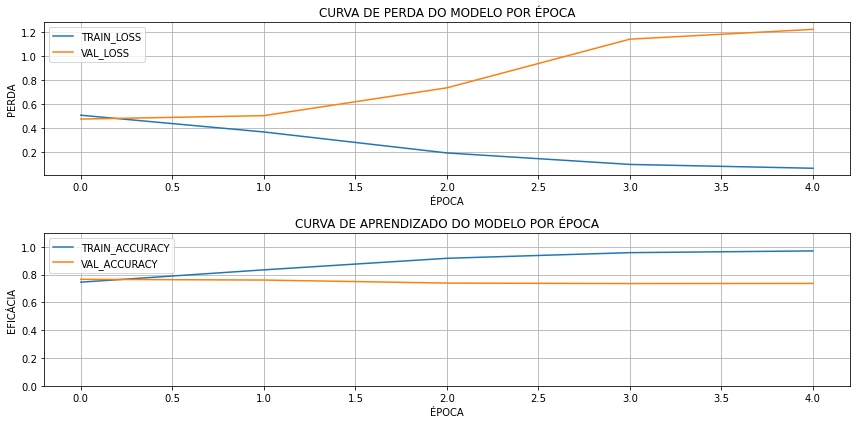

In [60]:
_, ax = plt.subplots(2,1,figsize=(12,6))

ax[0].plot(history.epoch, history.history['loss'], label = 'TRAIN_LOSS')
ax[0].plot(history.epoch, history.history['val_loss'], label = 'VAL_LOSS')
ax[0].set(title = 'CURVA DE PERDA DO MODELO POR ÉPOCA', xlabel='ÉPOCA', ylabel='PERDA')
ax[0].grid()
ax[0].legend()

ax[1].plot(history.epoch, history.history['accuracy'], label = 'TRAIN_ACCURACY')
ax[1].plot(history.epoch, history.history['val_accuracy'], label = 'VAL_ACCURACY')
ax[1].set(title = 'CURVA DE APRENDIZADO DO MODELO POR ÉPOCA',
          xlabel='ÉPOCA', ylabel='EFICÁCIA', ylim=(0,1.1))
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

# Etapa 5: Avaliação do modelo
## Avaliação

In [61]:
results = Dcnn.evaluate(X_test, y_test, batch_size=batch_size)
print(results)

72000/72000 [==============================] - 19s 269us/sample - loss: 1.2578 - accuracy: 0.7285
[1.2577850264708201, 0.7285]


In [62]:
y_pred = Dcnn.predict(X_test)

In [63]:
y_pred

array([[2.1651718e-05],
       [9.9858034e-01],
       [9.7870934e-01],
       ...,
       [3.7665722e-01],
       [9.3015106e-03],
       [9.9979180e-01]], dtype=float32)

In [64]:
y_pred = (y_pred > 0.5)
y_pred

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [ True]])

In [65]:
y_test

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [66]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[26673,  9327],
       [10221, 25779]], dtype=int64)

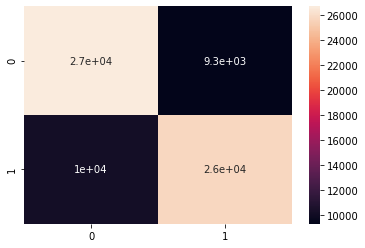

In [67]:
sns.heatmap(cm, annot=True);

## Previsões

In [68]:
text = 'you are so funny'
text = tokenizer.encode(text)
text

[4516, 10934, 3788, 687]

In [69]:
Dcnn(np.array([text]), training=False).numpy()

array([[0.999995]], dtype=float32)

In [70]:
text = 'i hate you'
text = tokenizer.encode(text)
text

[261, 63, 3187]

In [71]:
Dcnn(np.array([text]), training=False).numpy()

array([[0.00828578]], dtype=float32)